# Download data

In [ ]:
# %cd drive/MyDrive/DLCV
# !gdown 1LMIaOY8NSKWmGtbvTsjXcHVaYKnNN_9u -O hw1_data.zip

/content/drive/MyDrive/DLCV
Downloading...
From: https://drive.google.com/uc?id=1LMIaOY8NSKWmGtbvTsjXcHVaYKnNN_9u
To: /content/drive/MyDrive/DLCV/hw1_data.zip
100% 167M/167M [00:00<00:00, 253MB/s]


In [ ]:
# !mkdir hw1_data
# !unzip ./hw1_data.zip -d hw1_data

串流輸出內容已截斷至最後 5000 行。
  inflating: hw1_data/hw1_data/p2_data/train/1808_mask.png  
  inflating: hw1_data/hw1_data/p2_data/train/1900_sat.jpg  
  inflating: hw1_data/hw1_data/p2_data/train/0842_sat.jpg  
  inflating: hw1_data/hw1_data/p2_data/train/0232_mask.png  
  inflating: hw1_data/hw1_data/p2_data/train/0754_sat.jpg  
  inflating: hw1_data/hw1_data/p2_data/train/1710_mask.png  
  inflating: hw1_data/hw1_data/p2_data/train/1644_mask.png  
  inflating: hw1_data/hw1_data/p2_data/train/0607_sat.jpg  
  inflating: hw1_data/hw1_data/p2_data/train/1777_sat.jpg  
  inflating: hw1_data/hw1_data/p2_data/train/0643_sat.jpg  
  inflating: hw1_data/hw1_data/p2_data/train/1310_mask.png  
  inflating: hw1_data/hw1_data/p2_data/train/1684_sat.jpg  
  inflating: hw1_data/hw1_data/p2_data/train/0011_sat.jpg  
  inflating: hw1_data/hw1_data/p2_data/train/1248_mask.png  
  inflating: hw1_data/hw1_data/p2_data/train/1284_sat.jpg  
  inflating: hw1_data/hw1_data/p2_data/train/1235_sat.jpg  
  inflating: 

# Import


In [ ]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
import matplotlib.pyplot as plt
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [ ]:
%cd drive/MyDrive/DLCV
!ls

myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

/content/drive/MyDrive/DLCV
DLCV_hw1-1a.ipynb  dlcv_hw1_2b.py  hw1_data.zip		  resnet50_log.txt
DLCV_hw1-1b.ipynb  hw1-a	   hw2-b		  unet_log.txt
DLCV_hw1-2a.ipynb  hw1-b	   inception.pt
DLCV_hw1-2b.ipynb  hw1_data	   inceptionv3_best.ckpt


# Prepare dataset


In [ ]:
test_tfm = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((299, 299)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    
    
    transforms.RandomApply(transforms=[transforms.RandomHorizontalFlip(), transforms.RandomResizedCrop(size=(299, 299))], p = 0.7),
    transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.2, hue=0.1), transforms.RandomEqualize(), transforms.RandomSolarize(threshold=100.0)], p = 0.4),
    transforms.ToTensor(),
])

In [ ]:
class Dataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(Dataset).__init__()
        self.path = path

        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".png")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label

One ./hw1_data/hw1_data/p1_data/train_50 sample ./hw1_data/hw1_data/p1_data/train_50/0_0.png
One ./hw1_data/hw1_data/p1_data/val_50 sample ./hw1_data/hw1_data/p1_data/val_50/0_450.png


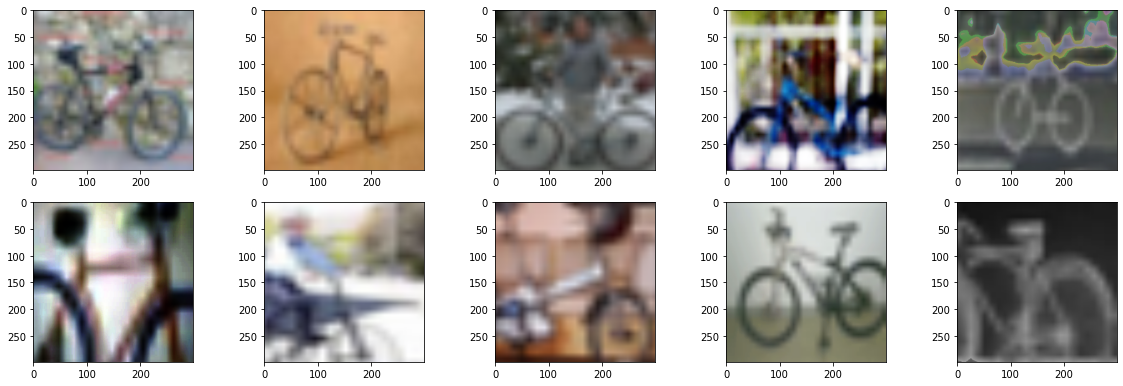

In [ ]:
batch_size = 128
_dataset_dir = "./hw1_data/hw1_data/p1_data"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
def show_images(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image.permute(1, 2, 0))

# show some train data
train_set = Dataset(os.path.join(_dataset_dir,"train_50"), tfm=train_tfm)
img = []
for i in range(10):
  img.append(train_set.__getitem__(i+100)[0])
show_images(img)


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = Dataset(os.path.join(_dataset_dir,"val_50"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
# resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False).to(device)
import torchvision.models as models
_exp_name = "inceptionv3"


In [ ]:
from numpy.core.numeric import outer
class MyInceptionV3(nn.Module):
    def __init__(self):
        super(MyInceptionV3, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.inceptionv3 = models.inception_v3(weights='IMAGENET1K_V1')
        self.fc = nn.Sequential(
            nn.BatchNorm1d(1000),
            # nn.Dropout(p=0.5), # new added
            nn.ReLU(),
            nn.Linear(1000, 50),
        )

    def forward(self, x):
        out = self.inceptionv3(x)
        # out = out.view(out.size()[0], -1)
        if not torch.is_tensor(out):
          out = out.logits
        return self.fc(out)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MyInceptionV3().to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
# "cuda" only when GPUs are available.

# The number of training epochs and patience.
n_epochs = 40
patience = 30 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.

print(model)
# model = models.vgg16_bn(pretrained=False).to(device)
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) 

checkpoint = torch.load("inception.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
init_epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(init_epoch, n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # print(np.shape(imgs.to(device)[0]))
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"./drive/MyDrive/DLCV/{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "./drive/MyDrive/DLCV/inception.pt")
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

MyInceptionV3(
  (inceptionv3): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3

  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 001/040 ] loss = 2.61562, acc = 0.36789


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 001/040 ] loss = 0.96299, acc = 0.73778
[ Valid | 001/040 ] loss = 0.96299, acc = 0.73778 -> best
Best model found at epoch 0, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 002/040 ] loss = 1.41683, acc = 0.61897


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 002/040 ] loss = 0.63286, acc = 0.81374
[ Valid | 002/040 ] loss = 0.63286, acc = 0.81374 -> best
Best model found at epoch 1, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 003/040 ] loss = 1.15832, acc = 0.68095


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 003/040 ] loss = 0.56176, acc = 0.83228
[ Valid | 003/040 ] loss = 0.56176, acc = 0.83228 -> best
Best model found at epoch 2, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 004/040 ] loss = 1.01455, acc = 0.72000


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 004/040 ] loss = 0.49810, acc = 0.84520
[ Valid | 004/040 ] loss = 0.49810, acc = 0.84520 -> best
Best model found at epoch 3, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 005/040 ] loss = 0.93738, acc = 0.73661


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 005/040 ] loss = 0.49894, acc = 0.84092
[ Valid | 005/040 ] loss = 0.49894, acc = 0.84092


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 006/040 ] loss = 0.86728, acc = 0.75887


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 006/040 ] loss = 0.46810, acc = 0.85533
[ Valid | 006/040 ] loss = 0.46810, acc = 0.85533 -> best
Best model found at epoch 5, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 007/040 ] loss = 0.82407, acc = 0.76978


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 007/040 ] loss = 0.49442, acc = 0.84685
[ Valid | 007/040 ] loss = 0.49442, acc = 0.84685


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 008/040 ] loss = 0.76673, acc = 0.78487


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 008/040 ] loss = 0.46015, acc = 0.86356
[ Valid | 008/040 ] loss = 0.46015, acc = 0.86356 -> best
Best model found at epoch 7, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 009/040 ] loss = 0.71518, acc = 0.79836


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 009/040 ] loss = 0.45894, acc = 0.85593
[ Valid | 009/040 ] loss = 0.45894, acc = 0.85593


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 010/040 ] loss = 0.69552, acc = 0.80510


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 010/040 ] loss = 0.47158, acc = 0.85308
[ Valid | 010/040 ] loss = 0.47158, acc = 0.85308


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 011/040 ] loss = 0.66943, acc = 0.81080


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 011/040 ] loss = 0.48010, acc = 0.85846
[ Valid | 011/040 ] loss = 0.48010, acc = 0.85846


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 012/040 ] loss = 0.64267, acc = 0.82032


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 012/040 ] loss = 0.44989, acc = 0.86340
[ Valid | 012/040 ] loss = 0.44989, acc = 0.86340


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 013/040 ] loss = 0.62039, acc = 0.82502


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 013/040 ] loss = 0.45587, acc = 0.86436
[ Valid | 013/040 ] loss = 0.45587, acc = 0.86436 -> best
Best model found at epoch 12, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 014/040 ] loss = 0.60422, acc = 0.82909


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 014/040 ] loss = 0.45443, acc = 0.86668
[ Valid | 014/040 ] loss = 0.45443, acc = 0.86668 -> best
Best model found at epoch 13, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 015/040 ] loss = 0.59630, acc = 0.83179


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 015/040 ] loss = 0.45869, acc = 0.87038
[ Valid | 015/040 ] loss = 0.45869, acc = 0.87038 -> best
Best model found at epoch 14, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 016/040 ] loss = 0.57226, acc = 0.83850


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 016/040 ] loss = 0.48041, acc = 0.85839
[ Valid | 016/040 ] loss = 0.48041, acc = 0.85839


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 017/040 ] loss = 0.56287, acc = 0.84017


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 017/040 ] loss = 0.49208, acc = 0.85983
[ Valid | 017/040 ] loss = 0.49208, acc = 0.85983


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 018/040 ] loss = 0.53649, acc = 0.84963


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 018/040 ] loss = 0.48801, acc = 0.86404
[ Valid | 018/040 ] loss = 0.48801, acc = 0.86404


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 019/040 ] loss = 0.54960, acc = 0.84612


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 019/040 ] loss = 0.48269, acc = 0.86535
[ Valid | 019/040 ] loss = 0.48269, acc = 0.86535


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 020/040 ] loss = 0.52840, acc = 0.85021


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 020/040 ] loss = 0.48259, acc = 0.86857
[ Valid | 020/040 ] loss = 0.48259, acc = 0.86857


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 021/040 ] loss = 0.53100, acc = 0.85067


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 021/040 ] loss = 0.50385, acc = 0.86140
[ Valid | 021/040 ] loss = 0.50385, acc = 0.86140


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 022/040 ] loss = 0.50917, acc = 0.85566


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 022/040 ] loss = 0.50200, acc = 0.86507
[ Valid | 022/040 ] loss = 0.50200, acc = 0.86507


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 023/040 ] loss = 0.49343, acc = 0.86070


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 023/040 ] loss = 0.48211, acc = 0.86535
[ Valid | 023/040 ] loss = 0.48211, acc = 0.86535


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 024/040 ] loss = 0.48059, acc = 0.86376


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 024/040 ] loss = 0.50078, acc = 0.86514
[ Valid | 024/040 ] loss = 0.50078, acc = 0.86514


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 025/040 ] loss = 0.48596, acc = 0.86490


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 025/040 ] loss = 0.52477, acc = 0.86045
[ Valid | 025/040 ] loss = 0.52477, acc = 0.86045


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 026/040 ] loss = 0.48240, acc = 0.86410


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 026/040 ] loss = 0.50372, acc = 0.87038
[ Valid | 026/040 ] loss = 0.50372, acc = 0.87038


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 027/040 ] loss = 0.48018, acc = 0.86333


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 027/040 ] loss = 0.52340, acc = 0.86464
[ Valid | 027/040 ] loss = 0.52340, acc = 0.86464


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 028/040 ] loss = 0.46600, acc = 0.87100


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 028/040 ] loss = 0.51103, acc = 0.86140
[ Valid | 028/040 ] loss = 0.51103, acc = 0.86140


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 029/040 ] loss = 0.46621, acc = 0.86667


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 029/040 ] loss = 0.52482, acc = 0.86500
[ Valid | 029/040 ] loss = 0.52482, acc = 0.86500


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 030/040 ] loss = 0.47051, acc = 0.87013


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 030/040 ] loss = 0.49872, acc = 0.86438
[ Valid | 030/040 ] loss = 0.49872, acc = 0.86438


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 031/040 ] loss = 0.43836, acc = 0.87668


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 031/040 ] loss = 0.49617, acc = 0.86317
[ Valid | 031/040 ] loss = 0.49617, acc = 0.86317


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 032/040 ] loss = 0.45036, acc = 0.87429


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 032/040 ] loss = 0.51626, acc = 0.86721
[ Valid | 032/040 ] loss = 0.51626, acc = 0.86721


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 033/040 ] loss = 0.43649, acc = 0.87928


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 033/040 ] loss = 0.49011, acc = 0.86737
[ Valid | 033/040 ] loss = 0.49011, acc = 0.86737


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 034/040 ] loss = 0.43013, acc = 0.87985


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 034/040 ] loss = 0.52097, acc = 0.86622
[ Valid | 034/040 ] loss = 0.52097, acc = 0.86622


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 035/040 ] loss = 0.43538, acc = 0.87733


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 035/040 ] loss = 0.54474, acc = 0.86404
[ Valid | 035/040 ] loss = 0.54474, acc = 0.86404


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 036/040 ] loss = 0.42482, acc = 0.87934


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 036/040 ] loss = 0.52702, acc = 0.87043
[ Valid | 036/040 ] loss = 0.52702, acc = 0.87043 -> best
Best model found at epoch 35, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 037/040 ] loss = 0.42027, acc = 0.88372


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 037/040 ] loss = 0.50196, acc = 0.87199
[ Valid | 037/040 ] loss = 0.50196, acc = 0.87199 -> best
Best model found at epoch 36, saving model


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 038/040 ] loss = 0.41918, acc = 0.88173


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 038/040 ] loss = 0.54355, acc = 0.85705
[ Valid | 038/040 ] loss = 0.54355, acc = 0.85705


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 039/040 ] loss = 0.42367, acc = 0.88103


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 039/040 ] loss = 0.52517, acc = 0.86466
[ Valid | 039/040 ] loss = 0.52517, acc = 0.86466


  0%|          | 0/176 [00:00<?, ?it/s]

[ Train | 040/040 ] loss = 0.40377, acc = 0.88649


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid | 040/040 ] loss = 0.51287, acc = 0.86409
[ Valid | 040/040 ] loss = 0.51287, acc = 0.86409


# Evaluation (using validatin dataset)

In [ ]:
%cd ..

/content


In [ ]:

!unzip ./drive/MyDrive/DLCV/hw1_data.zip -d hw1_data


One ./hw1_data/hw1_data/p1_data/train_50 sample ./hw1_data/hw1_data/p1_data/train_50/0_0.png
One ./hw1_data/hw1_data/p1_data/val_50 sample ./hw1_data/hw1_data/p1_data/val_50/0_450.png


  0%|          | 0/20 [00:00<?, ?it/s]

[ Valid ] loss = 0.50220, acc = 0.87165


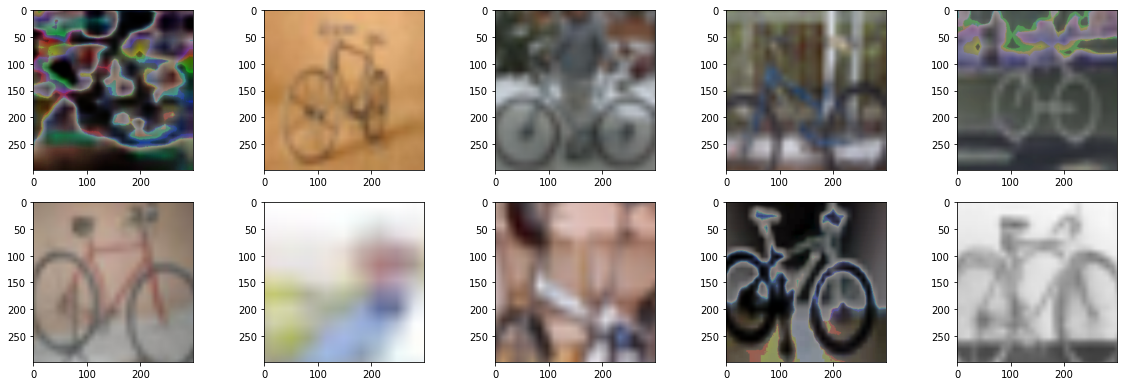

In [ ]:
# batch_size = 128
# _dataset_dir = "./hw1_data/hw1_data/p1_data"
# # Construct datasets.
# # The argument "loader" tells how torchvision reads the data.
# def show_images(images, figsize=(20,10), columns = 5):
#   plt.figure(figsize=figsize)
#   for i, image in enumerate(images):
#       plt.subplot(len(images) / columns + 1, columns, i + 1)
#       plt.imshow(image.permute(1, 2, 0))

# # show some train data
# train_set = Dataset(os.path.join(_dataset_dir,"train_50"), tfm=train_tfm)
# img = []
# for i in range(10):
#   img.append(train_set.__getitem__(i+100)[0])
# show_images(img)


# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
# valid_set = Dataset(os.path.join(_dataset_dir,"val_50"), tfm=test_tfm)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)


# criterion = nn.CrossEntropyLoss()
# model.eval()
# model.load_state_dict(
#         torch.load("./drive/MyDrive/DLCV/inceptionv3_best.ckpt")
#     )

# # These are used to record information in validation.
# valid_loss = []
# valid_accs = []

# # Iterate the validation set by batches.
# for batch in tqdm(valid_loader):

#     # A batch consists of image data and corresponding labels.
#     imgs, labels = batch
#     #imgs = imgs.half()

#     # We don't need gradient in validation.
#     # Using torch.no_grad() accelerates the forward process.
#     with torch.no_grad():
#         logits = model(imgs.to(device))

#     # We can still compute the loss (but not the gradient).
#     loss = criterion(logits, labels.to(device))

#     # Compute the accuracy for current batch.
#     acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

#     # Record the loss and accuracy.
#     valid_loss.append(loss.item())
#     valid_accs.append(acc)
#     #break

# # The average loss and accuracy for entire validation set is the average of the recorded values.
# valid_loss = sum(valid_loss) / len(valid_loss)
# valid_acc = sum(valid_accs) / len(valid_accs)

# # Print the information.
# print(f"[ Valid ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")